# Set up a global gridded subset regional CESM-MOM6 run

A typical workflow of utilizing CrocoDash consists of four main steps:

1. Generate a regional MOM6 domain.
2. Create the CESM case.
3. Prepare ocean forcing data.
4. Build and run the case.

# SECTION 1: Generate a regional MOM6 domain

We begin by defining a regional MOM6 domain using CrocoDash. To do so, we first carve out a subdomain from a 1/12 degree global grid. We then generate the topography by remapping an existing bathymetric dataset to our horizontal grid. Finally, we define a vertical grid.

## Step 1.1: Horizontal Grid

Extract a subgrid from a global grid using the `subgrid_from_supergrid` method:

In [1]:
from CrocoDash.grid import Grid

grid = Grid.subgrid_from_supergrid(
    path = "/glade/work/fredc/cesm/grid/MOM6/tx1_12v1/gridgen/ocean_hgrid_trimmed.nc",  # supergrid
    llc = (16.0, 192.0),  # (l)ower (l)eft (c)orner coords
    urc = (27.0, 209.0),  # (u)pper (r)ight (c)orner coords
    name = "hawaii_2"
)

## Step 1.2: Topography

In [2]:
from CrocoDash.topo import Topo

topo = Topo(
    grid = grid,
    min_depth = 9.5,
)

In [3]:
bathymetry_path='/glade/work/altuntas/croc/input/GEBCO_2024_coarse_x4.nc'

topo.interpolate_from_file(
    file_path = bathymetry_path,
    longitude_coordinate_name="lon",
    latitude_coordinate_name="lat",
    vertical_coordinate_name="elevation"
)

If bathymetry setup fails, rerun this function with write_to_file = True
Begin regridding bathymetry...

Original bathymetry size: 6.19 Mb
Regridded size: 0.69 Mb
Automatic regridding may fail if your domain is too big! If this process hangs or crashes,open a terminal with appropriate computational and resources try calling ESMF directly in the input directory None via

`mpirun -np NUMBER_OF_CPUS ESMF_Regrid -s bathymetry_original.nc -d bathymetry_unfinished.nc -m bilinear --src_var depth --dst_var depth --netcdf4 --src_regional --dst_regional`

For details see https://xesmf.readthedocs.io/en/latest/large_problems_on_HPC.html

Afterwards, we run the 'expt.tidy_bathymetry' method to skip the expensive interpolation step, and finishing metadata, encoding and cleanup.



Regridding successful! Now calling `tidy_bathymetry` method for some finishing touches...
setup bathymetry has finished successfully.
Tidy bathymetry: Reading in regridded bathymetry to fix up metadata...done. Filling in 

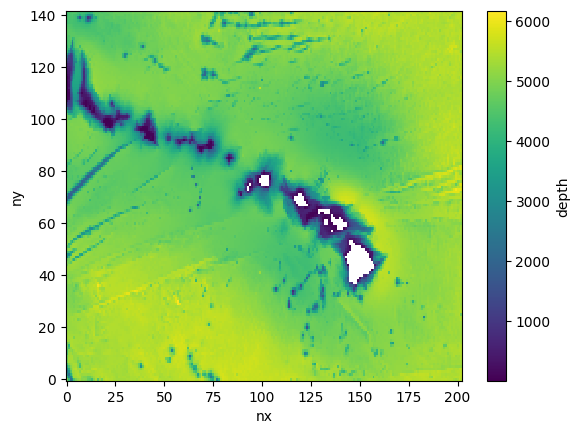

In [4]:
topo.depth.plot()

**TODO:** Implement a subset_global_topo-like method in mom6 and use it for this example instead of interpolation.

## Step 1.3: Vertical Grid

In [5]:
from CrocoDash.vgrid import VGrid

vgrid  = VGrid.hyperbolic(
    nk = 75,
    depth = topo.max_depth,
    ratio=20.0
)

In [6]:
print(vgrid.dz)

[  8.10953675   8.16076234   8.22142336   8.29324778   8.37827598
   8.47891565   8.59800561   8.73888989   8.90550317   9.10246895
   9.33521152   9.61008266   9.93450352  10.31712154  10.76798096
  11.29870416  11.92267853  12.65524057  13.5138449   14.51820037
  15.69034896  17.05465576  18.6376697   20.46780699  22.57480278
  24.98887486  27.73954875  30.85411099  34.35569027  38.26101727
  42.57798298  47.30319616  52.41981891  57.89601628  63.68436475
  69.72250501  75.93518847  82.23766625  88.54014404  94.75282749
 100.79096775 106.57931622 112.05551359 117.17213634 121.89734952
 126.21431524 130.11964223 133.62122151 136.73578375 139.48645764
 141.90052972 144.00752551 145.8376628  147.42067675 148.78498354
 149.95713214 150.9614876  151.82009194 152.55265397 153.17662834
 153.70735154 154.15821097 154.54082898 154.86524984 155.14012098
 155.37286355 155.56982934 155.73644261 155.87732689 155.99641685
 156.09705652 156.18208472 156.25390914 156.31457016 156.36579575]


# SECTION 2: Create the CESM case

After generating the MOM6 domain, the next step is to create a CESM case using CrocoDash. This process is straightforward and involves instantiating the CrocoDash Case object. The Case object requires the following inputs:

 - CESM Source Directory: A local path to a compatible CESM source copy.
 - Case Name: A unique name for the CESM case.
 - Input Directory: The directory where all necessary input files will be written.
 - MOM6 Domain Objects: The horizontal grid, topography, and vertical grid created in the previous section.
 - Project ID: (Optional) A project ID, if required by the machine.

In [7]:
from pathlib import Path

In [8]:
# CESM case (experiment) name
casename = "sub-glob-fresh-hawaii-t2"

# CESM source root (Update this path accordingly!!!)
cesmroot = Path.home() / "cesm3_0_beta04"

# Place where all your input files go 
inputdir = Path.home() / "croc_input" / casename
    
# CESM case directory
caseroot = Path.home() / "croc_cases" / casename

## Step 2.2: Create the Case

To create the CESM case, instantiate the `Case` object as shown below. This will automatically set up the CESM case based on the provided inputs: The `cesmroot` argument specifies the path to your local CESM source directory.
The `caseroot` argument defines the directory where the case will be created. CrocoDash will handle all necessary namelist modifications and XML changes to align with the MOM6 domain objects generated earlier.

In [10]:
from CrocoDash.case import Case

case = Case(
    cesmroot = cesmroot,
    caseroot = caseroot,
    inputdir = inputdir,
    compset = "1850_DATM%JRA_SLND_SICE_MOM6_SROF_SGLC_SWAV",
    ocn_grid = grid,
    ocn_vgrid = vgrid,
    ocn_topo = topo,
    project = 'NCGD0011',
    override = True,
)

INFO:  csp_solver:CspSolver initialized.


Setting ATM option to JRA for custom component set 1850_DATM%JRA_SLND_SICE_MOM6_SROF_SGLC_SWAV
Creating case...

• Updating ccs_config/modelgrid_aliases_nuopc.xml file to include the new resolution "sub-glob-fresh-hawaii-t2" consisting of the following component grids.
 atm grid: "TL319", lnd grid: "TL319", ocn grid: "hawaii_2".

• Updating ccs_config/component_grids_nuopc.xml file to include newly generated ocean grid "hawaii_2" with the following properties:
 nx: 203, ny: 142. ocean mesh: /glade/u/home/altuntas/croc_input/sub-glob-fresh-hawaii-t2/ocnice/ESMF_mesh_hawaii_2_664644.nc.

Running the create_newcase tool with the following command:

/glade/u/home/altuntas/cesm3_0_beta04/cime/scripts/create_newcase --compset 1850_DATM%JRA_SLND_SICE_MOM6_SROF_SGLC_SWAV --res sub-glob-fresh-hawaii-t2 --case /glade/u/home/altuntas/croc_cases/sub-glob-fresh-hawaii-t2 --machine derecho --run-unsupported --project NCGD0011 

The create_newcase command was successful.

Navigating to the case direc

INFO:	stage:SUCCESS: All stages are complete.


Case created successfully at /glade/u/home/altuntas/croc_cases/sub-glob-fresh-hawaii-t2.

To further customize, build, and run the case, navigate to the case directory in your terminal. To create another case, restart the notebook.



# Section 3: Prepare ocean forcing data

We need to cut out our ocean forcing. The package expects an initial condition and one time-dependent segment per non-land boundary. Naming convention is `"east_unprocessed"` for segments and `"ic_unprocessed"` for the initial condition.

In this notebook, we are forcing with the Copernicus Marine "Glorys" reanalysis dataset. There's a function in the `CrocoDash` package, called `configure_forcings`, that generates a bash script to download the correct boundary forcing files for your experiment. First, you will need to create an account with Copernicus, and then call `copernicusmarine login` to set up your login details on your machine. Then you can run the `get_glorys_data.sh` bash script.

## Step 3.1 Configure Initial Conditions and Forcings


In [11]:
case.configure_forcings(
    date_range = ["2020-01-01 00:00:00", "2020-02-01 00:00:00"],
)

INFO:CrocoDash.raw_data_access.datasets.glorys:This data access method retuns a script at path /glade/derecho/scratch/altuntas/tmp/tmpqi3qr5sg/get_glorys_data.sh to run to get access data 
INFO:CrocoDash.raw_data_access.datasets.glorys:This data access method retuns a script at path /glade/u/home/altuntas/croc_input/sub-glob-fresh-hawaii-t2/glorys/get_glorys_data.sh to run to get access data 
INFO:CrocoDash.raw_data_access.datasets.glorys:This data access method retuns a script at path /glade/u/home/altuntas/croc_input/sub-glob-fresh-hawaii-t2/glorys/get_glorys_data.sh to run to get access data 
INFO:CrocoDash.raw_data_access.datasets.glorys:This data access method retuns a script at path /glade/u/home/altuntas/croc_input/sub-glob-fresh-hawaii-t2/glorys/get_glorys_data.sh to run to get access data 
INFO:CrocoDash.raw_data_access.datasets.glorys:This data access method retuns a script at path /glade/u/home/altuntas/croc_input/sub-glob-fresh-hawaii-t2/glorys/get_glorys_data.sh to run to 

This means that some areas may only have one or two layers between the surface and sea floor. 
For increased stability, consider increasing the minimum depth, or adjusting the vertical coordinate to add more layers near the surface.


## Step 3.2 Run `get_glorys_data.sh`

In a terminal session, locate the `get_glorys_data.sh` script and execute it to download the initial conditions and boundary conditions. Follow the instructions printed by the `configure_forcings` method above.


**TODO:** user copernicusmarine python API within CrocoDash, instead of directing users to run it via CLI. Also, on a derecho login node, both CLI and API fails to run due to the computational demand. We also need to address that.

##  Step 3.3: Process forcing data

In this final step, we call the `process_forcings` method of CrocoDash to cut out and interpolate the initial condition as well as all boundaries. CrocoDash also updates MOM6 runtime parameters and CESM xml variables accordingly.

In [12]:
case.process_forcings()

INITIAL CONDITIONS
Regridding Velocities... Done.
Regridding Tracers... Done.
Regridding Free surface... Done.
Saving outputs... done setting up initial condition.
[########################################] | 100% Completed | 101.87 ms
Done.
[########################################] | 100% Completed | 101.86 ms
Done.
[########################################] | 100% Completed | 101.57 ms
Done.
[########################################] | 100% Completed | 101.72 ms
Done.
Adding parameter changes to user_nl_mom:

  ! Initial conditions
  INIT_LAYERS_FROM_Z_FILE = True
  TEMP_SALT_Z_INIT_FILE = init_tracers.nc
  Z_INIT_FILE_PTEMP_VAR = temp
  Z_INIT_ALE_REMAPPING = True
  TEMP_SALT_INIT_VERTICAL_REMAP_ONLY = True
  DEPRESS_INITIAL_SURFACE = True
  SURFACE_HEIGHT_IC_FILE = init_eta.nc
  SURFACE_HEIGHT_IC_VAR = eta_t
  VELOCITY_CONFIG = file
  VELOCITY_FILE = init_vel.nc

  ! Open boundary conditions
  OBC_NUMBER_OF_SEGMENTS = 4
  OBC_FREESLIP_VORTICITY = False
  OBC_FREESLIP_STRAIN = Fals

# Section 4: Build and run the case

After completing the previous steps, you are ready to build and run your CESM case. Begin by navigating to the case root directory specified during the case creation. Before proceeding, review the `user_nl_mom` file located in the case directory. This file contains MOM6 parameter settings that were automatically generated by CrocoDash. Carefully examine these parameters and make any necessary adjustments to fine-tune the model for your specific requirements. While CrocoDash aims to provide a solid starting point, further tuning and adjustments are typically necessary to improve the model for your use case.

Once you have reviewed and modified the parameters as needed, you can build and execute the case using the following commands: 
```
./case.build
./case.submit
```